# Source dependent analysis: adding source-dependent parameters

### Seiya Nozaki and Alvaro Mas Aguilar

-------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from lstchain.reco.dl1_to_dl2 import get_source_dependent_parameters
from lstchain.io import read_configuration_file, get_standard_config
from lstchain.io.io import dl1_params_src_dep_lstcam_key, write_dataframe, dl1_params_lstcam_key
from lstchain.io.io import(
    dl1_params_lstcam_key,
    dl1_params_src_dep_lstcam_key,
    dl2_params_lstcam_key,
    dl2_params_src_dep_lstcam_key,
    write_dataframe,
    get_srcdep_index_keys,
    get_srcdep_params
)
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
import os
import joblib
from lstchain.reco import dl1_to_dl2

In [2]:
# Check package versions
import numpy as np
import lstchain

print("numpy:", np.__version__)
print("lstchain", lstchain.__version__)

numpy: 1.21.5
lstchain 0.8.4


## Configuration file

In [4]:
data_directory='/fefs/aswg/workspace/analysis-school-2022' #Change it to yours

True


In [ ]:
configuration_file=data_directory+'/srcdep/ex1/lstchain_src_dep_config.json'
config = read_configuration_file(configuration_file)
print(config['source_dependent'])

In [5]:
config

{'source_config': {'EventSource': {'allowed_tels': [1, 2, 3, 4],
   'max_events': None},
  'LSTEventSource': {'default_trigger_type': 'ucts',
   'allowed_tels': [1],
   'min_flatfield_adc': 3000,
   'min_flatfield_pixel_fraction': 0.8,
   'calibrate_flatfields_and_pedestals': False,
   'EventTimeCalculator': {'dragon_reference_counter': None,
    'dragon_reference_time': None},
   'PointingSource': {'drive_report_path': None},
   'LSTR0Corrections': {'drs4_pedestal_path': None,
    'calibration_path': None,
    'drs4_time_calibration_path': None}}},
 'events_filters': {'intensity': [0, inf],
  'width': [0, inf],
  'length': [0, inf],
  'wl': [0, inf],
  'r': [0, inf],
  'leakage_intensity_width_2': [0, inf]},
 'tailcuts_clean_with_pedestal_threshold': {'picture_thresh': 6,
  'boundary_thresh': 3,
  'sigma': 2.5,
  'keep_isolated_pixels': False,
  'min_number_picture_neighbors': 2,
  'use_only_main_island': False,
  'delta_time': 2},
 'dynamic_cleaning': {'apply': True,
  'threshold': 2

# EXERCISE 1.Adding source dependent params to DL1 files 

## 1.1 Computing the source dependent parameters for WOBBLE MODE

Read the dl1 file

In [6]:
dl1_filename = data_directory+'/srcdep/ex1/dl1_LST-1.Run05552.0149.h5'

In [7]:
dl1_params = pd.read_hdf(dl1_filename, key=dl1_params_lstcam_key) #Use this key for standard dl1 params

In [8]:
dl1_params

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,mc_type,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type
0,5552,7897001,47.564608,1.677284,0.123948,0.903917,0.912375,1.434523,0.068761,0.004587,...,-9999,0.596240,1,50.0,50.0,16.0,1,1,1.628467e+09,32
1,5552,7897002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.628467e+09,32
2,5552,7897003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.628467e+09,32
3,5552,7897004,67.375060,1.828499,0.507073,-0.646049,0.821281,-0.905341,0.063670,0.004492,...,-9999,0.613250,1,50.0,50.0,16.0,1,1,1.628467e+09,32
4,5552,7897005,82.047094,1.914063,0.665830,0.298926,0.729853,0.421983,0.089584,0.004643,...,-9999,0.567172,1,50.0,50.0,16.0,1,1,1.628467e+09,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,5552,7911825,208.735060,2.319595,0.863502,0.418375,0.959517,0.451179,0.404678,0.010402,...,-9999,0.284065,1,50.0,50.0,16.0,1,1,1.628467e+09,32
14819,5552,7911826,56.773748,1.754148,0.455105,0.316447,0.554310,0.607584,0.060196,0.004342,...,-9999,0.569760,1,50.0,50.0,16.0,1,1,1.628467e+09,32
14820,5552,7911827,56.410550,1.751360,0.158803,1.034176,1.046297,1.418431,0.075853,0.004033,...,-9999,0.474232,1,50.0,50.0,16.0,1,1,1.628467e+09,32
14821,5552,7911828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.628467e+09,32


Now, we prepare the config file with the observation parameters, we give the mode of observation (on/wobble) and the position of the source:

In [9]:
config['observation_mode'] = 'wobble'
config['n_off_wobble'] = 1

# You need to specify the source ra/dec if source names are not registerd in astropy
config['source_ra'] = 330.6803874 #[deg]
config['source_dec'] = 42.27777178 #[deg]

We compute the source dependent parameters using the following line:

---
### Definition of the parameters    
    
    src_dep_params['expected_src_x'] = expected_src_pos_x_m
    src_dep_params['expected_src_y'] = expected_src_pos_y_m

    src_dep_params['dist'] = np.sqrt((data['x'] - expected_src_pos_x_m) ** 2 + (data['y'] - expected_src_pos_y_m) ** 2)

    disp, miss = camera_to_shower_coordinates(
        expected_src_pos_x_m,
        expected_src_pos_y_m,
        data['x'],
        data['y'],
        data['psi'])

    src_dep_params['time_gradient_from_source'] = data['time_gradient'] * np.sign(disp) * -1
    src_dep_params['skewness_from_source'] = data['skewness'] * np.sign(disp) * -1
    src_dep_params['alpha'] = np.rad2deg(np.arctan(np.abs(miss / disp)))

---

In [10]:
src_dep_df_real_wobble = pd.concat(get_source_dependent_parameters(dl1_params, config), axis=1)

In [11]:
src_dep_df_real_wobble

on                                                     \
      expected_src_x expected_src_y      dist time_gradient_from_source   
0           0.180398      -0.064883  0.970443                 11.485294   
1           0.180398      -0.064883       NaN                       NaN   
2           0.180398      -0.064883       NaN                       NaN   
3           0.180398      -0.064883  0.666686                 20.103542   
4           0.180398      -0.064883  0.606630                  4.093378   
...              ...            ...       ...                       ...   
14818       0.180405      -0.064925  0.836779                -28.226982   
14819       0.180405      -0.064925  0.470005                 -2.337988   
14820       0.180405      -0.064925  1.099313                 18.380530   
14821       0.180405      -0.064925       NaN                       NaN   
14822       0.180405      -0.064925  1.126965                 -1.283719   

                                             off_180                           \
      skewness_from_source      alpha expected_src_x expected_src_y      dist   
0                 0.058270  58.486165      -0.180398       0.064883  0.892527   
1                      NaN        NaN      -0.180398       0.064883       NaN   
2                      NaN        NaN      -0.180398       0.064883       NaN   
3                 0.362379  43.830920      -0.180398       0.064883  0.988960   
4                 0.193092  12.249533      -0.180398       0.064883  0.877997   
...                    ...        ...            ...            ...       ...   
14818             0.032902  87.737477      -0.180405       0.064925  1.102120   
14819             0.449957  43.672735      -0.180405       0.064925  0.683474   
14820             0.500609  30.986101      -0.180405       0.064925  1.026893   
14821                  NaN        NaN      -0.180405       0.064925       NaN   
14822             0.952538  70.427019      -0.180405       0.064925  0.954352   

                                                                           
      time_gradient_from_source skewness_from_source      alpha off_angle  
0                     11.485294             0.058270  81.758373     180.0  
1                           NaN                  NaN        NaN     180.0  
2                           NaN                  NaN        NaN     180.0  
3                     20.103542             0.362379  29.132480     180.0  
4                      4.093378             0.193092   9.140396     180.0  
...                         ...                  ...        ...       ...  
14818                -28.226982             0.032902  71.162821     180.0  
14819                 -2.337988             0.449957  11.030355     180.0  
14820                 18.380530             0.500609  10.571626     180.0  
14821                       NaN                  NaN        NaN     180.0  
14822                 -1.283719             0.952538  51.422242     180.0  

[14823 rows x 13 columns]

And we can explore the position of the source and the off regions in the camera (in our case 3 off regions):

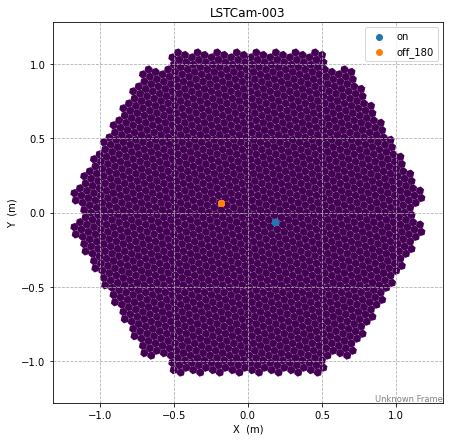

In [12]:
plt.figure(figsize=(7,7))

camera003 = CameraGeometry.from_name('LSTCam-003')
disp = CameraDisplay(camera003)

for i, k in enumerate(src_dep_df_real_wobble.columns.levels[0]):
    plt.scatter(src_dep_df_real_wobble[k].expected_src_x, src_dep_df_real_wobble[k].expected_src_y, label=k)
                    
plt.legend()
plt.grid(ls='--')
plt.show()

## Exploring the parameters

Using MultiIndex we have two different levels in the data:

In [13]:
print("Column (Level 0): ", src_dep_df_real_wobble.columns.levels[0])
print("Column (Level 1): ", src_dep_df_real_wobble.columns.levels[1])

Column (Level 0):  Index(['on', 'off_180'], dtype='object')
Column (Level 1):  Index(['alpha', 'dist', 'expected_src_x', 'expected_src_y', 'off_angle',
       'skewness_from_source', 'time_gradient_from_source'],
      dtype='object')


So for each position ('on','off_090','off_180',...) we have a set of source dependent parameters associated. For example, for the ON position:

In [14]:
src_dep_df_real_wobble['on']

,expected_src_x,expected_src_y,dist,time_gradient_from_source,skewness_from_source,alpha
0,0.180398,-0.064883,0.970443,11.485294,0.058270,58.486165
1,0.180398,-0.064883,NaN,NaN,NaN,NaN
2,0.180398,-0.064883,NaN,NaN,NaN,NaN
3,0.180398,-0.064883,0.666686,20.103542,0.362379,43.830920
4,0.180398,-0.064883,0.606630,4.093378,0.193092,12.249533
...,...,...,...,...,...,...
14818,0.180405,-0.064925,0.836779,-28.226982,0.032902,87.737477
14819,0.180405,-0.064925,0.470005,-2.337988,0.449957,43.672735
14820,0.180405,-0.064925,1.099313,18.380530,0.500609,30.986101
14821,0.180405,-0.064925,NaN,NaN,NaN,NaN


And for the OFF position at 180 degrees:

In [15]:
src_dep_df_real_wobble['off_180']

,expected_src_x,expected_src_y,dist,time_gradient_from_source,skewness_from_source,alpha,off_angle
0,-0.180398,0.064883,0.892527,11.485294,0.058270,81.758373,180.0
1,-0.180398,0.064883,NaN,NaN,NaN,NaN,180.0
2,-0.180398,0.064883,NaN,NaN,NaN,NaN,180.0
3,-0.180398,0.064883,0.988960,20.103542,0.362379,29.132480,180.0
4,-0.180398,0.064883,0.877997,4.093378,0.193092,9.140396,180.0
...,...,...,...,...,...,...,...
14818,-0.180405,0.064925,1.102120,-28.226982,0.032902,71.162821,180.0
14819,-0.180405,0.064925,0.683474,-2.337988,0.449957,11.030355,180.0
14820,-0.180405,0.064925,1.026893,18.380530,0.500609,10.571626,180.0
14821,-0.180405,0.064925,NaN,NaN,NaN,NaN,180.0


## Computing the source dependent parameters for ON MODE

In [16]:
config['observation_mode'] = 'on'

In [17]:
src_dep_df_real_on = pd.concat(get_source_dependent_parameters(dl1_params, config), axis=1)

In [18]:
src_dep_df_real_on

on                                                     \
      expected_src_x expected_src_y      dist time_gradient_from_source   
0                0.0            0.0  0.912375                 11.485294   
1                0.0            0.0       NaN                       NaN   
2                0.0            0.0       NaN                       NaN   
3                0.0            0.0  0.821281                 20.103542   
4                0.0            0.0  0.729853                  4.093378   
...              ...            ...       ...                       ...   
14818            0.0            0.0  0.959517                -28.226982   
14819            0.0            0.0  0.554310                 -2.337988   
14820            0.0            0.0  1.046297                 18.380530   
14821            0.0            0.0       NaN                       NaN   
14822            0.0            0.0  1.026478                 -1.283719   

                                       
      skewness_from_source      alpha  
0                 0.058270  69.628817  
1                      NaN        NaN  
2                      NaN        NaN  
3                 0.362379  35.043571  
4                 0.193092   0.422544  
...                    ...        ...  
14818             0.032902  78.308192  
14819             0.449957  24.249649  
14820             0.500609  21.130249  
14821                  NaN        NaN  
14822             0.952538  61.719961  

[14823 rows x 6 columns]

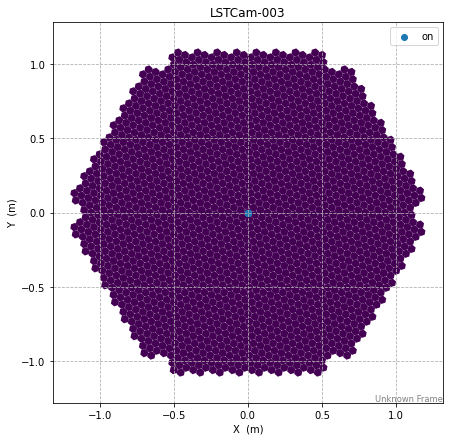

In [19]:
plt.figure(figsize=(7,7))

camera003 = CameraGeometry.from_name('LSTCam-003')
disp = CameraDisplay(camera003)

for i, k in enumerate(src_dep_df_real_on.columns.levels[0]):
    plt.scatter(src_dep_df_real_on[k].expected_src_x, src_dep_df_real_on[k].expected_src_y, label=k)
                    
plt.legend()
plt.grid(ls='--')
plt.show()

## Computing the source dependent parameters for MC

In [20]:
dl1_filename_gamma = data_directory+'/srcdep/ex1/mc/dl1_gamma_20deg_180deg_run114___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5'
dl1_filename_proton = data_directory+'/srcdep/ex1/mc/dl1_proton_20deg_180deg_run1162___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5'

In [21]:
dl1_params_gamma = pd.read_hdf(dl1_filename_gamma, key=dl1_params_lstcam_key)
dl1_params_proton = pd.read_hdf(dl1_filename_proton, key=dl1_params_lstcam_key)

In [22]:
src_dep_df_gamma = pd.concat(get_source_dependent_parameters(dl1_params_gamma, config), axis=1)
src_dep_df_proton = pd.concat(get_source_dependent_parameters(dl1_params_proton, config), axis=1)

### MC gamma

In [23]:
dl1_params_gamma

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,width,...,trigger_type,trigger_time,event_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y
0,114,605,129.114975,2.110977,0.050916,0.000710,0.050921,0.013937,0.074127,0.052454,...,32,1.606642e+09,32,0.144560,-0.000710,0.144562,-0.004909,1.0,0.195476,0.0
1,114,703,50.701284,1.705019,0.027270,0.200232,0.202080,1.435436,0.083721,0.033101,...,32,1.606642e+09,32,0.168206,-0.200232,0.261508,-0.872103,1.0,0.195476,0.0
2,114,1903,92.538941,1.966325,-0.041097,-0.098955,0.107150,-1.964431,0.075119,0.051409,...,32,1.606642e+09,32,0.236574,0.098955,0.256436,0.396170,1.0,0.195476,0.0
3,114,1907,79.185575,1.898646,0.496589,0.074372,0.502127,0.148660,0.091697,0.028341,...,32,1.606642e+09,32,-0.301112,-0.074372,0.310161,0.242143,-1.0,0.195476,0.0
4,114,2002,66.909214,1.825486,-0.069943,0.068206,0.097694,2.368769,0.090847,0.056055,...,32,1.606642e+09,32,0.265419,-0.068206,0.274043,-0.251532,1.0,0.195476,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171,114,998206,144.608656,2.160194,0.433156,-0.581412,0.725027,-0.930498,0.106345,0.045291,...,32,1.606648e+09,32,-0.237680,0.581412,0.628118,-1.182729,-1.0,0.195476,0.0
2172,114,999304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32,1.606648e+09,32,NaN,NaN,NaN,NaN,NaN,0.195476,0.0
2173,114,999800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32,1.606648e+09,32,NaN,NaN,NaN,NaN,NaN,0.195476,0.0
2174,114,999807,57.632632,1.760668,0.203895,0.902306,0.925056,1.348557,0.081828,0.054813,...,32,1.606648e+09,32,-0.008419,-0.902306,0.902345,1.561466,-1.0,0.195476,0.0


In [24]:
src_dep_df_gamma

on                                                     \
     expected_src_x expected_src_y      dist time_gradient_from_source   
0          0.195476            0.0  0.144562                 -1.384350   
1          0.195476            0.0  0.261508                -13.284135   
2          0.195476            0.0  0.256436                 -3.903360   
3          0.195476            0.0  0.310161                 -1.694489   
4          0.195476            0.0  0.274043                 -0.445887   
...             ...            ...       ...                       ...   
2171       0.195476            0.0  0.628118                  8.796444   
2172       0.195476            0.0       NaN                       NaN   
2173       0.195476            0.0       NaN                       NaN   
2174       0.195476            0.0  0.902345                 20.900510   
2175       0.195476            0.0  0.531372                  9.007735   

                                      
     skewness_from_source      alpha  
0                0.415643  70.046557  
1                0.516437   6.630970  
2               -0.360324   6.495334  
3               -0.017628  11.272466  
4                0.253902  26.122171  
...                   ...        ...  
2171            -0.124415   0.914889  
2172                  NaN        NaN  
2173                  NaN        NaN  
2174            -0.233276   5.985164  
2175             0.294772   2.909609  

[2176 rows x 6 columns]

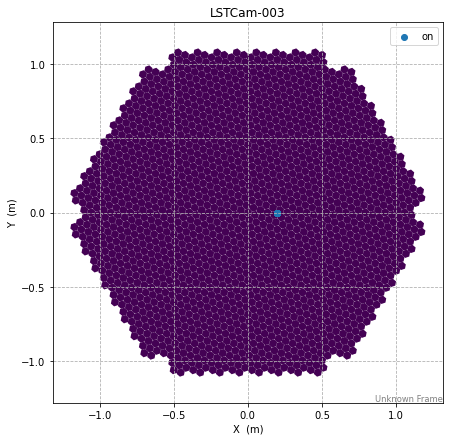

In [25]:
plt.figure(figsize=(7,7))

camera003 = CameraGeometry.from_name('LSTCam-003')
disp = CameraDisplay(camera003)

for i, k in enumerate(src_dep_df_gamma.columns.levels[0]):
    plt.scatter(src_dep_df_gamma[k].expected_src_x, src_dep_df_gamma[k].expected_src_y, label=k)
                    
plt.legend()
plt.grid(ls='--')
plt.show()

### MC proton

In [26]:
dl1_params_proton

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,width,...,trigger_type,trigger_time,event_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y
0,1162,12608,510.256837,2.707789,-0.808417,-0.306952,0.864730,-2.778712,0.192999,0.078122,...,32,1.606707e+09,32,-0.689726,0.692907,0.977672,-0.787699,-1.0,-1.498143,0.385954
1,1162,32308,518.827343,2.715023,0.374304,-0.836173,0.916127,-1.149907,0.181094,0.082163,...,32,1.606707e+09,32,-1.652558,-1.388507,2.158449,0.698787,-1.0,-1.278254,-2.224680
2,1162,47506,77.299542,1.888177,-0.159412,0.478053,0.503931,1.892662,0.089297,0.048251,...,32,1.606707e+09,32,2.344251,-0.093513,2.346116,-0.039869,1.0,2.184839,0.384539
3,1162,63909,1029.756803,3.012735,-0.506610,0.547408,0.745862,2.317506,0.630142,0.112126,...,32,1.606707e+09,32,1.083470,1.687301,2.005216,0.999972,1.0,0.576860,2.234709
4,1162,202005,42.090786,1.624187,0.016693,-0.758411,0.758595,-1.548790,0.054911,0.039759,...,32,1.606707e+09,32,0.224608,3.869195,3.875709,1.512811,1.0,0.241300,3.110784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,1162,9842606,316.583612,2.500488,-0.690622,0.293961,0.750581,2.739174,0.102468,0.084583,...,32,1.606713e+09,32,-0.325022,0.343950,0.473224,-0.813684,-1.0,-1.015645,0.637911
301,1162,9906102,79.555403,1.900670,-0.701967,0.505189,0.864855,2.517783,0.092057,0.067529,...,32,1.606713e+09,32,-1.859562,1.434191,2.348377,-0.656964,-1.0,-2.561529,1.939380
302,1162,9911202,131.315427,2.118316,-0.334938,1.040046,1.092648,1.882350,0.066584,0.032474,...,32,1.606713e+09,32,-0.278043,0.071774,0.287158,-0.252626,-1.0,-0.612981,1.111820
303,1162,9966606,156.586391,2.194754,-0.622275,-0.681196,0.922634,-2.311022,0.083634,0.067468,...,32,1.606713e+09,32,1.056384,0.487907,1.163615,0.432677,1.0,0.434108,-0.193289


In [27]:
src_dep_df_proton

on                                                     \
    expected_src_x expected_src_y      dist time_gradient_from_source   
0         0.195479  -3.108624e-12  1.049775                 -0.749020   
1         0.195479  -3.108624e-12  0.855081                  0.092081   
2         0.195479  -3.108624e-12  0.595384                 -3.310464   
3         0.195479  -3.108624e-12  0.890272                -22.349395   
4         0.195479  -3.108624e-12  0.779199                -13.156146   
..             ...            ...       ...                       ...   
300       0.195479  -3.108624e-12  0.933589                 -1.301408   
301       0.195479  -3.108624e-12  1.029866                -12.302322   
302       0.195479  -3.108624e-12  1.167492                 -2.822594   
303       0.195479  -3.108624e-12  1.064307                 -0.963440   
304       0.195479  -3.108624e-12  1.042665                 -4.807675   

                                     
    skewness_from_source      alpha  
0               0.465209  41.161003  
1              -0.032935  62.821515  
2              -0.376232  83.215719  
3              -0.187692  85.290727  
4               0.041038  66.887297  
..                   ...        ...  
300             0.168099  62.971385  
301            -0.161528  56.664496  
302            -0.407270  13.438581  
303             0.488192  60.221017  
304            -0.421422  14.478619  

[305 rows x 6 columns]

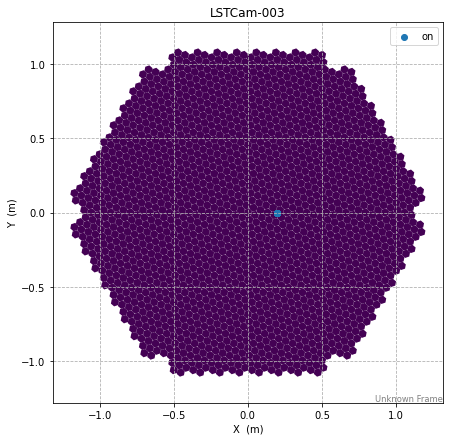

In [28]:
plt.figure(figsize=(7,7))

camera003 = CameraGeometry.from_name('LSTCam-003')
disp = CameraDisplay(camera003)

for i, k in enumerate(src_dep_df_proton.columns.levels[0]):
    plt.scatter(src_dep_df_proton[k].expected_src_x, src_dep_df_proton[k].expected_src_y, label=k)
                    
plt.legend()
plt.grid(ls='--')
plt.show()

## 1.2 Reading DL1 files with source dependent parameters

We can read the source dependent parameters in the DL1 files using the dl1_params_src_dep_lstcam_key

In [49]:
dl1_filename = data_directory+'/srcdep/ex1/dl1_LST-1.Run05552.0149.h5'

In [50]:
dl1_srcindep_df = pd.read_hdf(dl1_filename, key=dl1_params_lstcam_key)

In [51]:
dl1_srcdep_df = pd.read_hdf(dl1_filename, key=dl1_params_src_dep_lstcam_key)

In [52]:
dl1_srcdep_df

,"('on', 'expected_src_x')","('on', 'expected_src_y')","('on', 'dist')","('on', 'time_gradient_from_source')","('on', 'skewness_from_source')","('on', 'alpha')","('off_180', 'expected_src_x')","('off_180', 'expected_src_y')","('off_180', 'dist')","('off_180', 'time_gradient_from_source')","('off_180', 'skewness_from_source')","('off_180', 'alpha')","('off_180', 'off_angle')"
0,0.180398,-0.064883,0.970443,11.485294,0.058270,58.486165,-0.180398,0.064883,0.892527,11.485294,0.058270,81.758373,180.0
1,0.180398,-0.064883,NaN,NaN,NaN,NaN,-0.180398,0.064883,NaN,NaN,NaN,NaN,180.0
2,0.180398,-0.064883,NaN,NaN,NaN,NaN,-0.180398,0.064883,NaN,NaN,NaN,NaN,180.0
3,0.180398,-0.064883,0.666686,20.103542,0.362379,43.830920,-0.180398,0.064883,0.988960,20.103542,0.362379,29.132480,180.0
4,0.180398,-0.064883,0.606630,4.093378,0.193092,12.249533,-0.180398,0.064883,0.877997,4.093378,0.193092,9.140396,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,0.180405,-0.064925,0.836779,-28.226982,0.032902,87.737477,-0.180405,0.064925,1.102120,-28.226982,0.032902,71.162821,180.0
14819,0.180405,-0.064925,0.470005,-2.337988,0.449957,43.672735,-0.180405,0.064925,0.683474,-2.337988,0.449957,11.030355,180.0
14820,0.180405,-0.064925,1.099313,18.380530,0.500609,30.986101,-0.180405,0.064925,1.026893,18.380530,0.500609,10.571626,180.0
14821,0.180405,-0.064925,NaN,NaN,NaN,NaN,-0.180405,0.064925,NaN,NaN,NaN,NaN,180.0


In [53]:
srcdep_index_keys = get_srcdep_index_keys(dl1_filename)
print(srcdep_index_keys.values)

['off_180' 'on']


In [54]:
dl1_srcindep_df

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,mc_type,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,ucts_trigger_type,trigger_time,event_type
0,5552,7897001,47.564608,1.677284,0.123948,0.903917,0.912375,1.434523,0.068761,0.004587,...,-9999,0.596240,1,50.0,50.0,16.0,1,1,1.628467e+09,32
1,5552,7897002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.628467e+09,32
2,5552,7897003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.628467e+09,32
3,5552,7897004,67.375060,1.828499,0.507073,-0.646049,0.821281,-0.905341,0.063670,0.004492,...,-9999,0.613250,1,50.0,50.0,16.0,1,1,1.628467e+09,32
4,5552,7897005,82.047094,1.914063,0.665830,0.298926,0.729853,0.421983,0.089584,0.004643,...,-9999,0.567172,1,50.0,50.0,16.0,1,1,1.628467e+09,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,5552,7911825,208.735060,2.319595,0.863502,0.418375,0.959517,0.451179,0.404678,0.010402,...,-9999,0.284065,1,50.0,50.0,16.0,1,1,1.628467e+09,32
14819,5552,7911826,56.773748,1.754148,0.455105,0.316447,0.554310,0.607584,0.060196,0.004342,...,-9999,0.569760,1,50.0,50.0,16.0,1,1,1.628467e+09,32
14820,5552,7911827,56.410550,1.751360,0.158803,1.034176,1.046297,1.418431,0.075853,0.004033,...,-9999,0.474232,1,50.0,50.0,16.0,1,1,1.628467e+09,32
14821,5552,7911828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999,NaN,1,50.0,50.0,16.0,1,1,1.628467e+09,32


In [55]:
dl1_srcdep_df

,"('on', 'expected_src_x')","('on', 'expected_src_y')","('on', 'dist')","('on', 'time_gradient_from_source')","('on', 'skewness_from_source')","('on', 'alpha')","('off_180', 'expected_src_x')","('off_180', 'expected_src_y')","('off_180', 'dist')","('off_180', 'time_gradient_from_source')","('off_180', 'skewness_from_source')","('off_180', 'alpha')","('off_180', 'off_angle')"
0,0.180398,-0.064883,0.970443,11.485294,0.058270,58.486165,-0.180398,0.064883,0.892527,11.485294,0.058270,81.758373,180.0
1,0.180398,-0.064883,NaN,NaN,NaN,NaN,-0.180398,0.064883,NaN,NaN,NaN,NaN,180.0
2,0.180398,-0.064883,NaN,NaN,NaN,NaN,-0.180398,0.064883,NaN,NaN,NaN,NaN,180.0
3,0.180398,-0.064883,0.666686,20.103542,0.362379,43.830920,-0.180398,0.064883,0.988960,20.103542,0.362379,29.132480,180.0
4,0.180398,-0.064883,0.606630,4.093378,0.193092,12.249533,-0.180398,0.064883,0.877997,4.093378,0.193092,9.140396,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,0.180405,-0.064925,0.836779,-28.226982,0.032902,87.737477,-0.180405,0.064925,1.102120,-28.226982,0.032902,71.162821,180.0
14819,0.180405,-0.064925,0.470005,-2.337988,0.449957,43.672735,-0.180405,0.064925,0.683474,-2.337988,0.449957,11.030355,180.0
14820,0.180405,-0.064925,1.099313,18.380530,0.500609,30.986101,-0.180405,0.064925,1.026893,18.380530,0.500609,10.571626,180.0
14821,0.180405,-0.064925,NaN,NaN,NaN,NaN,-0.180405,0.064925,NaN,NaN,NaN,NaN,180.0


And extract the params for each position. For the ON position (source pos):

In [56]:
on_df_srcdep=get_srcdep_params(dl1_filename,'on')

In [57]:
on_df_srcdep

,expected_src_x,expected_src_y,dist,time_gradient_from_source,skewness_from_source,alpha
0,0.180398,-0.064883,0.970443,11.485294,0.058270,58.486165
1,0.180398,-0.064883,NaN,NaN,NaN,NaN
2,0.180398,-0.064883,NaN,NaN,NaN,NaN
3,0.180398,-0.064883,0.666686,20.103542,0.362379,43.830920
4,0.180398,-0.064883,0.606630,4.093378,0.193092,12.249533
...,...,...,...,...,...,...
14818,0.180405,-0.064925,0.836779,-28.226982,0.032902,87.737477
14819,0.180405,-0.064925,0.470005,-2.337988,0.449957,43.672735
14820,0.180405,-0.064925,1.099313,18.380530,0.500609,30.986101
14821,0.180405,-0.064925,NaN,NaN,NaN,NaN


In [58]:
pd.concat([dl1_srcindep_df, on_df_srcdep], axis=1)

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,trigger_type,ucts_trigger_type,trigger_time,event_type,expected_src_x,expected_src_y,dist,time_gradient_from_source,skewness_from_source,alpha
0,5552,7897001,47.564608,1.677284,0.123948,0.903917,0.912375,1.434523,0.068761,0.004587,...,1,1,1.628467e+09,32,0.180398,-0.064883,0.970443,11.485294,0.058270,58.486165
1,5552,7897002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1.628467e+09,32,0.180398,-0.064883,NaN,NaN,NaN,NaN
2,5552,7897003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1.628467e+09,32,0.180398,-0.064883,NaN,NaN,NaN,NaN
3,5552,7897004,67.375060,1.828499,0.507073,-0.646049,0.821281,-0.905341,0.063670,0.004492,...,1,1,1.628467e+09,32,0.180398,-0.064883,0.666686,20.103542,0.362379,43.830920
4,5552,7897005,82.047094,1.914063,0.665830,0.298926,0.729853,0.421983,0.089584,0.004643,...,1,1,1.628467e+09,32,0.180398,-0.064883,0.606630,4.093378,0.193092,12.249533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,5552,7911825,208.735060,2.319595,0.863502,0.418375,0.959517,0.451179,0.404678,0.010402,...,1,1,1.628467e+09,32,0.180405,-0.064925,0.836779,-28.226982,0.032902,87.737477
14819,5552,7911826,56.773748,1.754148,0.455105,0.316447,0.554310,0.607584,0.060196,0.004342,...,1,1,1.628467e+09,32,0.180405,-0.064925,0.470005,-2.337988,0.449957,43.672735
14820,5552,7911827,56.410550,1.751360,0.158803,1.034176,1.046297,1.418431,0.075853,0.004033,...,1,1,1.628467e+09,32,0.180405,-0.064925,1.099313,18.380530,0.500609,30.986101
14821,5552,7911828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1.628467e+09,32,0.180405,-0.064925,NaN,NaN,NaN,NaN


For the off position

In [59]:
off_df_srcdep=get_srcdep_params(dl1_filename,'off_180')

In [60]:
pd.concat([dl1_srcindep_df, off_df_srcdep], axis=1)

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,ucts_trigger_type,trigger_time,event_type,expected_src_x,expected_src_y,dist,time_gradient_from_source,skewness_from_source,alpha,off_angle
0,5552,7897001,47.564608,1.677284,0.123948,0.903917,0.912375,1.434523,0.068761,0.004587,...,1,1.628467e+09,32,-0.180398,0.064883,0.892527,11.485294,0.058270,81.758373,180.0
1,5552,7897002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.628467e+09,32,-0.180398,0.064883,NaN,NaN,NaN,NaN,180.0
2,5552,7897003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.628467e+09,32,-0.180398,0.064883,NaN,NaN,NaN,NaN,180.0
3,5552,7897004,67.375060,1.828499,0.507073,-0.646049,0.821281,-0.905341,0.063670,0.004492,...,1,1.628467e+09,32,-0.180398,0.064883,0.988960,20.103542,0.362379,29.132480,180.0
4,5552,7897005,82.047094,1.914063,0.665830,0.298926,0.729853,0.421983,0.089584,0.004643,...,1,1.628467e+09,32,-0.180398,0.064883,0.877997,4.093378,0.193092,9.140396,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,5552,7911825,208.735060,2.319595,0.863502,0.418375,0.959517,0.451179,0.404678,0.010402,...,1,1.628467e+09,32,-0.180405,0.064925,1.102120,-28.226982,0.032902,71.162821,180.0
14819,5552,7911826,56.773748,1.754148,0.455105,0.316447,0.554310,0.607584,0.060196,0.004342,...,1,1.628467e+09,32,-0.180405,0.064925,0.683474,-2.337988,0.449957,11.030355,180.0
14820,5552,7911827,56.410550,1.751360,0.158803,1.034176,1.046297,1.418431,0.075853,0.004033,...,1,1.628467e+09,32,-0.180405,0.064925,1.026893,18.380530,0.500609,10.571626,180.0
14821,5552,7911828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.628467e+09,32,-0.180405,0.064925,NaN,NaN,NaN,NaN,180.0
